<img src='https://static.wixstatic.com/media/e9b721_888e9daa53994dfd9d2214ad1a823fcc~mv2.png/v1/fit/w_1000%2Ch_205%2Cal_c/file.png'/>

In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [15]:
from torch import nn

# Create Dataset (Multiclass)

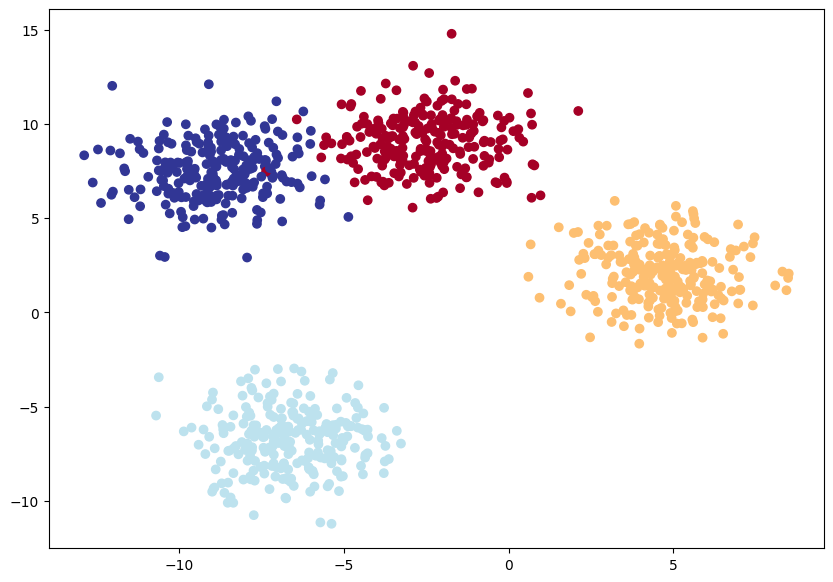

In [13]:
# Set hyper parameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create Data
X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES, # X-labels
                           centers=NUM_CLASSES, # y labels 
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

# Build multi-class classification model

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [22]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 

    loss = loss_fn(y_logits, y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
        

Epoch: 0 | Loss: 1.60748 | Test Loss: 1.39316
Epoch: 10 | Loss: 0.77336 | Test Loss: 0.68809
Epoch: 20 | Loss: 0.27060 | Test Loss: 0.23249
Epoch: 30 | Loss: 0.12161 | Test Loss: 0.10456
Epoch: 40 | Loss: 0.07541 | Test Loss: 0.06374
Epoch: 50 | Loss: 0.05643 | Test Loss: 0.04645
Epoch: 60 | Loss: 0.04671 | Test Loss: 0.03738
Epoch: 70 | Loss: 0.04099 | Test Loss: 0.03188
Epoch: 80 | Loss: 0.03727 | Test Loss: 0.02821
Epoch: 90 | Loss: 0.03469 | Test Loss: 0.02560


In [23]:
from helper_functions import plot_decision_boundary

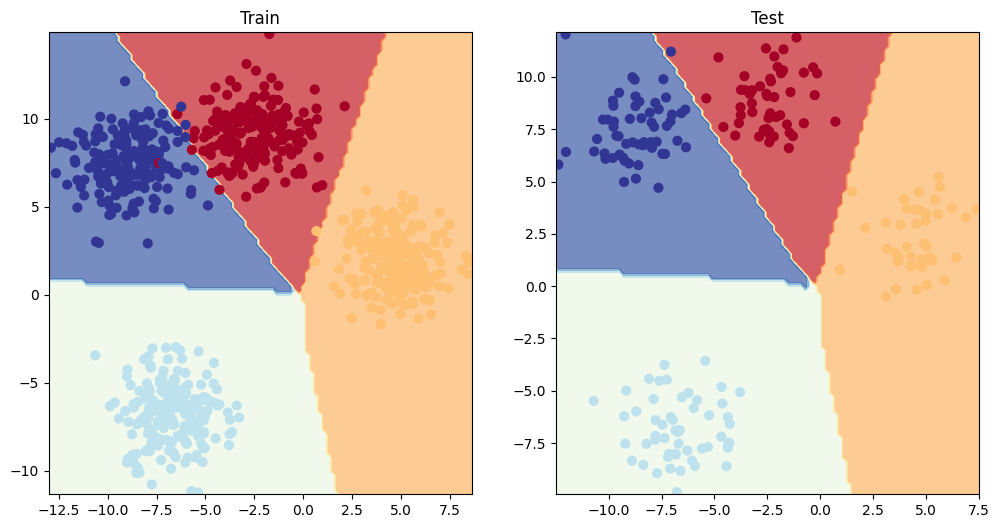

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

In [26]:
# !pip install torchmetrics

   ---------------------------------------- 0.0/840.2 kB ? eta -:--:--
   ---------------- ----------------------- 348.2/840.2 kB 7.2 MB/s eta 0:00:01
   ----------------------------------- ---- 737.3/840.2 kB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 840.2/840.2 kB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/819.5 kB ? eta -:--:--
   ------- -------------------------------- 153.6/819.5 kB 4.5 MB/s eta 0:00:01
   ----------------- ---------------------- 358.4/819.5 kB 3.7 MB/s eta 0:00:01
   ------------------------- -------------- 522.2/819.5 kB 4.7 MB/s eta 0:00:01
   ----------------------------------- ---- 727.0/819.5 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 819.5/819.5 kB 3.7 MB/s eta 0:00:00


In [29]:
from torchmetrics import Accuracy

In [33]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

In [40]:
torchmetrics_accuracy(test_pred, y_blob_test)

tensor(0.9950, device='cuda:0')